# 4. Results figures and tables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, sem, ttest_rel
from sklearn.metrics import r2_score, auc, roc_auc_score
import json
import scipy
import matplotlib.ticker as mtick
import geopandas as gpd
from matplotlib.colors import ListedColormap

In [2]:
def clean_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tight_layout

In [3]:
def metric(x, y, keyword='pearson'):
    if keyword == 'pearson':
        return np.corrcoef(x, y)[0][1]
    elif keyword == 'spearman':
        return spearmanr(x, y)[0]
    elif keyword == 'r2':
        return r2_score(x, y)
    else:
        return ''

In [4]:
def get_title(country):
    if country == 'us':
        return 'United States'
    elif 'india_condensed' in country:
        return f'India'# - {country.split("_")[-1]}'
    else:
        return country.title().split('/')[-1]

In [5]:
def diff_in_means_stars(vals1, vals2, paired_ttest=False):
    
    if paired_ttest:
        pval = scipy.stats.ttest_rel(vals1, vals2).pvalue                   
    else:
        pval = scipy.stats.ttest_ind(vals1, vals2, equal_var=False).pvalue                     

    if pval < 0.001:
        stars = ' (***)'
    elif pval < 0.01:
        stars = ' (**)'
    elif pval < 0.05:
        stars = ' (*)'
    else:
        stars = ''
    return stars

In [6]:
figure_path = '/home/em/fairness_figures_replication/'
#figure_path = '/home/erolf/fairsiml_figs/'

countries = [('us', 'FINCP', 'StatePUMA'),
             ('mexico', 'asset_index', 'municipality'),
             ('india_condensed_regions_25_max_tiles_100', 'secc_cons_pc_combined', 'condensed_shrug_id'),     
             ('dhs/colombia', 'wealth', 'cluster'),
             ('dhs/honduras', 'wealth', 'cluster'),
             ('dhs/indonesia', 'wealth', 'cluster'),
             ('dhs/nigeria', 'wealth', 'cluster'),
             ('dhs/kenya', 'wealth', 'cluster'),
             ('dhs/philippines', 'wealth', 'cluster'),
             ('dhs/peru', 'wealth', 'cluster')
]

In [7]:
spatial = 'no_spatial'
fpath = '/data/mosaiks/replication/simulations/'

summary_stats = []
summary_means = []
summary_stds = []

for country, poverty, _ in countries:
    
    # Read poverty simulations
    sims = pd.read_csv(fpath + country + '/' + poverty + '_' + spatial + '.csv')
    sims = sims.rename({'yhat':'yhat_pov', 'y':'y_pov'}, axis=1).drop('Unnamed: 0', axis=1)
    
    # Read rural simulations, and to poverty simulations
    sims_rural = pd.read_csv('/data/mosaiks/simulations_normalized/' + country + '/rural_' + spatial + '.csv')
    sims['rural'] = sims_rural['y']
    sims['yhat_rural'] = sims_rural['yhat']
    
    # Combine simulations into a single dataframe
    sims = sims[sims['split'] == 'test']
    dfs = [sims[sims['sim'] == i] for i in sims['sim'].unique()]
    
    # Calculate measures of fit for each simulation
    r2_pov_povhat, pearson_pov_povhat, spearman_pov_povhat = [], [], []
    pearson_pov_rural, spearman_pov_rural = [], []
    pearson_pov_ruralhat, spearman_pov_ruralhat = [], []
    for i in range(len(dfs)):
        
        r2_pov_povhat.append(metric(dfs[i]['y_pov'], dfs[i]['yhat_pov'], 'r2'))
        pearson_pov_povhat.append(metric(dfs[i]['y_pov'], dfs[i]['yhat_pov'], 'pearson'))
        spearman_pov_povhat.append(metric(dfs[i]['y_pov'], dfs[i]['yhat_pov'], 'spearman'))
        pearson_pov_rural.append(-metric(dfs[i]['y_pov'], dfs[i]['rural'].astype(int), 'pearson'))
        spearman_pov_rural.append(-metric(dfs[i]['y_pov'], dfs[i]['rural'].astype(int), 'spearman'))
        pearson_pov_ruralhat.append(metric(dfs[i]['y_pov'], dfs[i]['yhat_rural'], 'pearson'))
        spearman_pov_ruralhat.append(metric(dfs[i]['y_pov'], dfs[i]['yhat_rural'], 'spearman'))
        
    metrics = [r2_pov_povhat, pearson_pov_povhat, spearman_pov_povhat, pearson_pov_rural, spearman_pov_rural,
              pearson_pov_ruralhat, spearman_pov_ruralhat]
    
    # Add to table
    title = get_title(country)
    summary_stats.append([title] + ['%.2f (%.2f)' % (np.mean(x), np.std(x)) for x in metrics])
    summary_means.append([title] + [np.mean(x) for x in metrics])
    summary_stds.append([title] + [np.std(x) for x in metrics])

panel_a_columns = ['$R^2(w, \hat{w})$', '$\rho_p(w, \hat{w})$', '$\rho_s(w, \hat{w})$']
panel_b_columns = ['$\rho_p(w, u)$', '$\rho_s(w, u)$']
panel_c_columns = ['$\rho_p(w, \hat{u})$', '$\rho_s(w, \hat{u})$']
columns = ['Country'] + panel_a_columns + panel_b_columns + panel_c_columns
summary_stats = pd.DataFrame(summary_stats, columns=columns)
summary_means = pd.DataFrame(summary_means, columns=columns)
summary_stds = pd.DataFrame(summary_stds, columns=columns)

In [8]:
spatial = 'no_spatial'
fpath = '/data/mosaiks/replication/simulations/'
PERCENTILE_TARGETING = 20
all_runs = {}

for country, poverty, key in countries:
    
    # Load simulations
    print(country, end='\r')
    sims = pd.read_csv(fpath + country + '/' + poverty + '_' + spatial + '.csv')
    sims_rural = pd.read_csv(fpath + country + '/rural_' + spatial + '.csv')
    sims['rural'] = sims_rural['y']
    sims['rural_hat'] = sims_rural['yhat']
    sims = sims[sims['split'] == 'test']
    dfs = [sims[sims['sim'] == i].copy() for i in sims['sim'].unique()]
    
    # Calculate evaluation metrics for each simulation
    runs = []
    for data in dfs:
        
        # Add indications of error for each observation to simulation
        mse = np.mean((data['yhat'].values.flatten() - data['y'].values.flatten())**2)
        data['y_noised'] = data['y'].values.flatten() + np.random.normal(0, np.sqrt(mse), len(data))
        data['error'] = data['yhat'] - data['y']
        data['percent_error'] = data['error']/data['y']
        data['error_noised'] = data['y_noised'] - data['y']
        data['percent_error_noised'] = data['error_noised']/data['y']
        data['y_rank'] = data['y'].rank()
        data['yhat_rank'] = data['yhat'].rank()
        data['y_noised_rank'] = data['y_noised'].rank()
        data['rank_error'] = data['yhat_rank'] - data['y_rank']
        data['rank_error'] = (data['rank_error'] - data['rank_error'].mean())/data['rank_error'].std()
        data['rank_noised_error'] = data['y_noised_rank'] - data['y_rank']
        data['rank_noised_error'] = (data['rank_noised_error'] - data['rank_noised_error'].mean())/\
            data['rank_noised_error'].std()
        results_predicted, results_noised = {}, {}
        above_median = data[data['rural'] == 1]
        below_median = data[data['rural'] == 0]

        # Calculate measures of fit, overall and by group
        results_predicted['r2_overall'] = r2_score(data['y'], data['yhat'])
        results_noised['r2_overall'] = r2_score(data['y'], data['y_noised'])
        results_predicted['pearson_overall'] = np.corrcoef(data['y'], data['yhat'])[0][1]
        results_noised['pearson_overall'] = np.corrcoef(data['y'], data['y_noised'])[0][1]
        results_predicted['spearman_overall'] = spearmanr(data['y'], data['yhat'])[0]
        results_noised['spearman_overall'] = spearmanr(data['y'], data['y_noised'])[0]
        results_predicted['mae_overall'] = data['error'].mean()
        results_noised['mae_overall'] = data['error_noised'].mean()
        results_predicted['r2_above'] = r2_score(above_median['y'], above_median['yhat'])
        results_predicted['r2_below'] = r2_score(below_median['y'], below_median['yhat'])
        results_noised['r2_above'] = r2_score(above_median['y'], above_median['y_noised'])
        results_noised['r2_below'] = r2_score(below_median['y'], below_median['y_noised'])
        results_predicted['pearson_above'] = np.corrcoef(above_median['y'], above_median['yhat'])[0][1]
        results_predicted['pearson_below'] = np.corrcoef(below_median['y'], below_median['yhat'])[0][1]
        results_noised['pearson_above'] = np.corrcoef(above_median['y'], above_median['y_noised'])[0][1]
        results_noised['pearson_below'] = np.corrcoef(below_median['y'], below_median['y_noised'])[0][1]
        results_predicted['spearman_above'] = spearmanr(above_median['y'], above_median['yhat'])[0]
        results_predicted['spearman_below'] = spearmanr(below_median['y'], below_median['yhat'])[0]
        results_noised['spearman_above'] = spearmanr(above_median['y'], above_median['y_noised'])[0]
        results_noised['spearman_below'] = spearmanr(below_median['y'], below_median['y_noised'])[0]
        results_predicted['mae_above'] = above_median['error'].mean()
        results_predicted['mae_below'] = below_median['error'].mean()
        results_noised['mae_above'] = above_median['error_noised'].mean()
        results_noised['mae_below'] = below_median['error_noised'].mean()
        results_predicted['rank_above'] = above_median['rank_error'].mean()
        results_predicted['rank_below'] = below_median['rank_error'].mean()
        results_noised['rank_above'] = above_median['rank_noised_error'].mean()
        results_noised['rank_below'] = below_median['rank_noised_error'].mean()
        
        # Calculate summary statistics representing 'drivers' of unfairness
        results_predicted['std'] = np.std(data['yhat'])
        results_predicted['std_above'] = np.std(above_median['yhat'])
        results_predicted['std_below'] = np.std(below_median['yhat'])
        results_predicted['std_truth'] = np.std(data['y'])
        results_predicted['std_truth_above'] = np.std(above_median['y'])
        results_predicted['std_truth_below'] = np.std(below_median['y'])
        results_predicted['urban_wealth_corr'] = spearmanr(data['yhat'], data['rural_hat'])[0]

        # Calculate metrics for targeting simulation
        results_predicted['group_alloc_curve_true'] = []
        results_predicted['group_alloc_curve_proxy'] = []
        results_noised['group_alloc_curve_true'] = []
        results_noised['group_alloc_curve_proxy'] = []
        
        grid = np.arange(3, 101, 1)
       #grid = [20]
        for p, percentile in enumerate(grid):

            # Get cut-off value for predicted, true, and noised versions of labels
            prediction_thresh = np.percentile(data['yhat'], percentile)
            true_thresh = np.percentile(data['y'], percentile)
            noised_thresh = np.percentile(data['y_noised'], percentile)

            # Identify regions below cut-off value
            prediction_pumas = data[data['yhat'] < prediction_thresh]
            true_pumas = data[data['y'] < true_thresh]
            noised_pumas = data[data['y_noised'] < noised_thresh]

            # Record allocation to each group at percentile (PUMA-level)                     
            group_alloc_true = 100*(true_pumas['rural'].sum()/len(true_pumas))
            group_alloc_proxy = 100*(prediction_pumas['rural'].sum()/len(prediction_pumas))
            group_alloc_noised = 100*(noised_pumas['rural'].sum()/len(noised_pumas))
            results_predicted['group_alloc_curve_true'].append(group_alloc_true)
            results_predicted['group_alloc_curve_proxy'].append(group_alloc_proxy)
            results_noised['group_alloc_curve_true'].append(group_alloc_true)
            results_noised['group_alloc_curve_proxy'].append(group_alloc_noised)
            

            # Record allocations and recall separately if this is the threshold of interest
            if percentile == PERCENTILE_TARGETING:
                results_predicted['group_alloc_true'] = group_alloc_true
                results_predicted['group_alloc_proxy'] = group_alloc_proxy
                results_noised['group_alloc_true'] = group_alloc_true
                results_noised['group_alloc_proxy'] = group_alloc_noised
                
                # Recall overall
                results_predicted['recall'] = \
                    len(true_pumas.merge(prediction_pumas, on=['y', 'yhat', 'sim'], how='inner'))/len(true_pumas)
                
                # Recall for rural
                rural = data[data['rural'] == 1].copy()
                prediction_thresh = np.percentile(rural['yhat'], percentile)
                true_thresh = np.percentile(rural['y'], percentile)
                prediction_pumas = rural[rural['yhat'] < prediction_thresh]
                true_pumas = rural[rural['y'] < true_thresh]
                results_predicted['recall_rural'] = \
                    len(true_pumas.merge(prediction_pumas, on=['y', 'yhat', 'sim'], how='inner'))/len(true_pumas)
                
                # Recall for urban
                urban = data[data['rural'] == 0].copy()
                prediction_thresh = np.percentile(urban['yhat'], percentile)
                true_thresh = np.percentile(urban['y'], percentile)
                prediction_pumas = urban[urban['yhat'] < prediction_thresh]
                true_pumas = urban[urban['y'] < true_thresh]
                results_predicted['recall_urban'] = \
                    len(true_pumas.merge(prediction_pumas, on=['y', 'yhat', 'sim'], how='inner'))/len(true_pumas)
                
        results_predicted['auc_true'] = auc(grid, results_predicted['group_alloc_curve_true'])
        results_predicted['auc_proxy'] = auc(grid, results_predicted['group_alloc_curve_proxy'])
        
        # Record data
        runs.append((results_predicted, results_noised))
    all_runs[country] = runs

### Figure 1

In [9]:
order = ['Colombia', 'Honduras','India', 'Indonesia', 'Kenya', 'Mexico', 'Nigeria', 'Peru', 'Philippines',
         'United States']

In [10]:
country_names = [country[0] for country in countries]
overallp, ruralp, urbanp = [], [], []
for c, country in enumerate(country_names):
    overall = pd.DataFrame([all_runs[country][i][0]['spearman_overall'] for i in range(100)], columns=['p'])
    overall['country'] = get_title(country)
    overallp.append(overall)
    urban = pd.DataFrame([all_runs[country][i][0]['spearman_below'] for i in range(100)], columns=['p'])
    urban['country'] = get_title(country)
    urbanp.append(urban)
    rural = pd.DataFrame([all_runs[country][i][0]['spearman_above'] for i in range(100)], columns=['p'])
    rural['country'] = get_title(country)
    ruralp.append(rural)   

In [11]:
country_names = [country[0] for country in countries]
overallp, ruralp, urbanp = [], [], []
for c, country in enumerate(country_names):
    overall = pd.DataFrame([all_runs[country][i][0]['recall'] for i in range(100)], columns=['r'])
    overall['country'] = get_title(country)
    overallp.append(overall)
    urban = pd.DataFrame([all_runs[country][i][0]['recall_urban'] for i in range(100)], columns=['r'])
    urban['country'] = get_title(country)
    urbanp.append(urban)
    rural = pd.DataFrame([all_runs[country][i][0]['recall_rural'] for i in range(100)], columns=['r'])
    rural['country'] = get_title(country)
    ruralp.append(rural)   
overall = pd.concat(overallp)
overall['g'] = 'Overall'
rural = pd.concat(ruralp)
rural['g'] = 'Rural'
urban = pd.concat(urbanp)
urban['g'] = 'Urban'
df_r = pd.concat([overall, rural, urban])

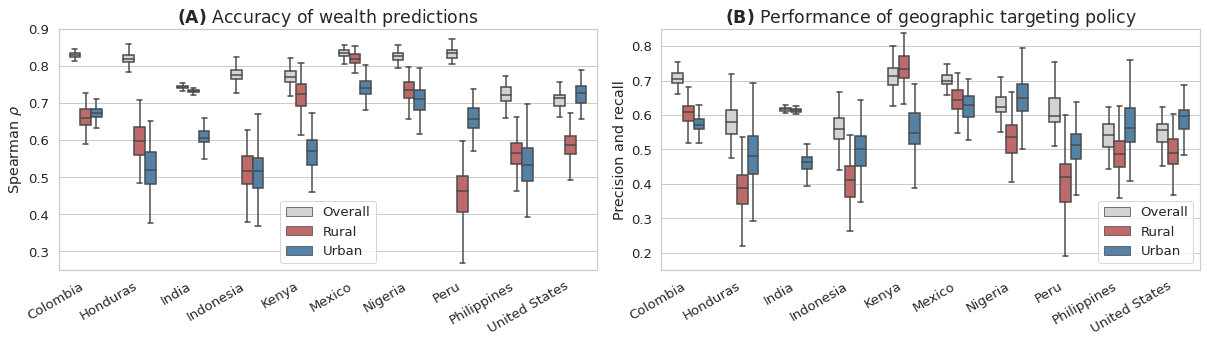

In [12]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(17, 5))


# Panel A
country_names = [country[0] for country in countries]
overallp, ruralp, urbanp = [], [], []
for c, country in enumerate(country_names):
    overall = pd.DataFrame([all_runs[country][i][0]['spearman_overall'] for i in range(100)], columns=['p'])
    overall['country'] = get_title(country)
    overallp.append(overall)
    urban = pd.DataFrame([all_runs[country][i][0]['spearman_below'] for i in range(100)], columns=['p'])
    urban['country'] = get_title(country)
    urbanp.append(urban)
    rural = pd.DataFrame([all_runs[country][i][0]['spearman_above'] for i in range(100)], columns=['p'])
    rural['country'] = get_title(country)
    ruralp.append(rural)   
overall = pd.concat(overallp)
overall['g'] = 'Overall'
rural = pd.concat(ruralp)
rural['g'] = 'Rural'
urban = pd.concat(urbanp)
urban['g'] = 'Urban'
df_p = pd.concat([overall, rural, urban])
df_p['order'] = df_p['country'].apply(lambda x: order.index(x))
df_p = df_p.sort_values(['order', 'g'], ascending=True)

# Plot data for Panel B
palette = {'Overall': 'lightgrey', 'Urban': 'steelblue', 'Rural':'indianred'}
sns.boxplot(data=df_p, x='country', y='p', hue='g', showfliers=False, palette=palette, width=0.6,
           ax=ax[0])
ax[0].set_ylim(0.25, 0.9)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha='right')
ax[0].set_ylabel('Spearman ' + r'$\rho$')
ax[0].get_legend().set_title('')
ax[0].set_title(r'$\bf(A)}$ Accuracy of wealth predictions', fontsize='large')
ax[0].set_xlabel('')
x0, x1 = ax[0].get_xlim()
y0, y1 = ax[0].get_ylim()

# Panel A
country_names = [country[0] for country in countries]
overallp, ruralp, urbanp = [], [], []
for c, country in enumerate(country_names):
    overall = pd.DataFrame([all_runs[country][i][0]['recall'] for i in range(100)], columns=['r'])
    overall['country'] = get_title(country)
    overallp.append(overall)
    urban = pd.DataFrame([all_runs[country][i][0]['recall_urban'] for i in range(100)], columns=['r'])
    urban['country'] = get_title(country)
    urbanp.append(urban)
    rural = pd.DataFrame([all_runs[country][i][0]['recall_rural'] for i in range(100)], columns=['r'])
    rural['country'] = get_title(country)
    ruralp.append(rural)   
overall = pd.concat(overallp)
overall['g'] = 'Overall'
rural = pd.concat(ruralp)
rural['g'] = 'Rural'
urban = pd.concat(urbanp)
urban['g'] = 'Urban'
df_r = pd.concat([overall, rural, urban])
df_r['order'] = df_r['country'].apply(lambda x: order.index(x))
df_r = df_r.sort_values(['order', 'g'], ascending=True)

# Plot data for Panel B
palette = {'Overall': 'lightgrey', 'Urban': 'steelblue', 'Rural':'indianred'}
sns.boxplot(data=df_r, x='country', y='r', hue='g', showfliers=False, palette=palette, width=.6,
           ax=ax[1])
ax[1].set_ylim(0.15, 0.85)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='right')
ax[1].set_ylabel('Precision and recall')
ax[1].get_legend().set_title('')
ax[1].set_title(r'$\bf(B)}$ Performance of geographic targeting policy', fontsize='large')
x0, x1 = ax[1].get_xlim()
y0, y1 = ax[1].get_ylim()

plt.tight_layout()
#plt.savefig(f'{figure_path}/Figure1.png', dpi=500)
plt.show()

### Figure S6

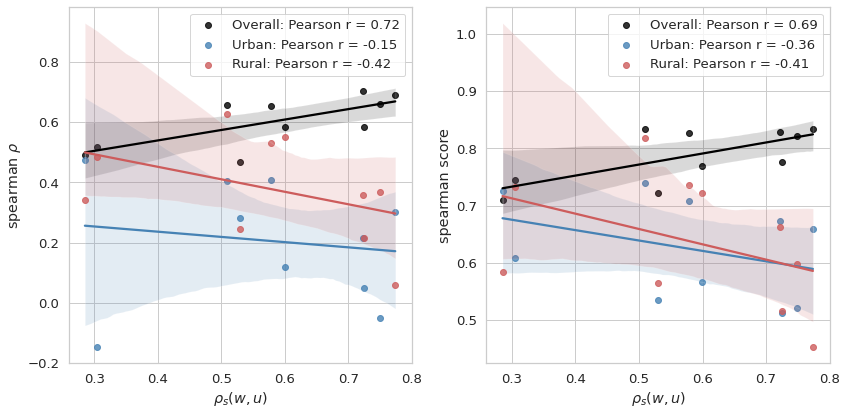

In [13]:
sns.set(font_scale=1.2, style='whitegrid')

fig, axes = plt.subplots(1,2, figsize=(12,6))
for k,key in enumerate(['r2', 'spearman']):
    ax = axes[k]
    overallp, ruralp, urbanp = [], [], []
    for c, country in enumerate(country_names):
        overall = pd.DataFrame([np.mean([all_runs[country][i][0][f'{key}_overall'] for i in range(100)])], 
                               columns=['p'])
        overall['country'] = get_title(country)
        overallp.append(overall)
        urban = pd.DataFrame([np.mean([all_runs[country][i][0][f'{key}_below'] for i in range(100)])], 
                             columns=['p'])
        urban['country'] = get_title(country)
        urbanp.append(urban)
        rural = pd.DataFrame([np.mean([all_runs[country][i][0][f'{key}_above'] for i in range(100)])],
                             columns=['p'])
        rural['country'] = get_title(country)
        ruralp.append(rural)  

    overall = pd.concat(overallp)
    overall['g'] = 'Overall'
    rural = pd.concat(ruralp)
    rural['g'] = 'Rural'
    urban = pd.concat(urbanp)
    urban['g'] = 'Urban'
    df_p = pd.concat([overall, rural, urban])

    df_p['r'] = 0

    for country in np.unique(df_p.country.values):
        val_this_country = summary_means[summary_means['Country'] == country]['$\rho_s(w, u)$'].values[0]
        df_p.loc[df_p.country == country,'r'] = val_this_country

    palette = {'Overall': 'black', 'Urban': 'steelblue', 'Rural':'indianred'}


    for g in ['Overall','Urban','Rural']:
        df_g = df_p[df_p.g == g]
        pearsonr = scipy.stats.pearsonr(df_g['r'],df_g['p'])[0]
        sns.regplot(data=df_g, x='r', y = 'p', color=palette[g], ax=ax, 
                    label= f'{g}: Pearson r = {pearsonr.round(2)}'
                    #ci=None
                   )

    ax.legend()

    ax.set_xlim(.26,.8)
    ax.set_ylabel(f'{key} score')
    ax.set_xlabel(r'$\rho_s(w, u)$')
    
axes[0].set_ylabel(r'$R^2$ score')
axes[0].set_ylabel(r'spearman $\rho$')
plt.tight_layout()

#plt.savefig(f'{figure_path}/FigureS6.png', dpi=500)

### Figure S4

In [15]:
country_order = ['Colombia', 'Honduras', 'India', 'Indonesia', 'Kenya', 'Mexico', 'Nigeria', 'Peru',
                'Philippines', 'US']
country_code_order = ['dhs/colombia', 'dhs/honduras', 'india_condensed_regions_25_max_tiles_100', 
                      'dhs/indonesia', 'dhs/kenya', 'mexico', 'dhs/nigeria', 'dhs/peru', 'dhs/philippines', 'us']

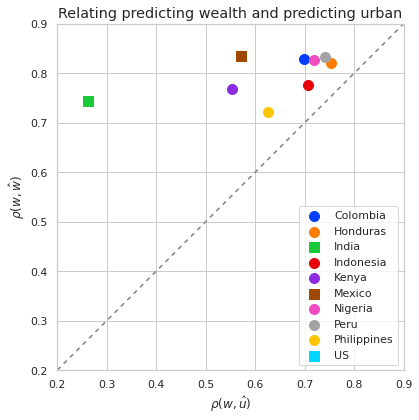

In [16]:
# Create figure
colors = sns.color_palette("bright")
sns.set(font_scale=1, style='whitegrid')

s = 1
fig, ax = plt.subplots(1, figsize=(8*s, 6*s))

# Get data from Table 1 for Panel A
n = 100
fig_means = summary_means.copy()
fig_ses = summary_stds.copy()[['Country','$\rho_s(w, \hat{w})$']]
fig_ses['$\rho_s(w, \hat{w})$'] = summary_stds.copy()['$\rho_s(w, \hat{w})$'] / np.sqrt(n)
fig_ses['$\rho_s(w, \hat{u})$'] = summary_stds.copy()['$\rho_s(w, \hat{u})$'] / np.sqrt(n)

# Plot points in Panel A
for c, country in enumerate(country_order):
    marker = 's' if country in ['US', 'Mexico', 'India'] else 'o'
    country_means = fig_means[fig_means['Country'] == country]
    country_ses = fig_ses[fig_ses['Country'] == country]
    ax.scatter(country_means['$\rho_s(w, \hat{u})$'],
               country_means['$\rho_s(w, \hat{w})$'], 
               s=100, 
               label=country, marker=marker, color=colors[c])
    
    
# Clean up Panel A
ax.plot([0, 1], [0, 1], color='grey', dashes=[3, 3])
ax.set_ylabel(r'$\rho(w, \hat{w})$')
ax.set_xlabel(r'$\rho(w, \hat{u})$')
ax.legend(loc='best')
ax.set_xlim(0.2, 0.9)
ax.set_ylim(0.2, 0.9)
ax.set_aspect('equal')
ax.set_title(r'Relating predicting wealth and predicting urban', fontsize='large')

# Clean up and save entire figure
plt.tight_layout()
#plt.savefig(f'{figure_path}/FigureS4.png', dpi=500)
plt.show()

### Table S3

In [17]:
summary_stats

,Country,"$R^2(w, \hat{w})$","$\rho_p(w, \hat{w})$","$\rho_s(w, \hat{w})$","$\rho_p(w, u)$","$\rho_s(w, u)$","$\rho_p(w, \hat{u})$","$\rho_s(w, \hat{u})$"
0,United States,0.49 (0.06),0.72 (0.03),0.71 (0.02),0.28 (0.03),0.29 (0.03),0.28 (0.03),0.24 (0.04)
1,Mexico,0.66 (0.03),0.82 (0.01),0.83 (0.01),0.51 (0.03),0.51 (0.03),0.56 (0.04),0.57 (0.04)
2,India,0.52 (0.01),0.72 (0.00),0.74 (0.00),0.35 (0.01),0.30 (0.01),0.28 (0.01),0.26 (0.01)
3,Colombia,0.70 (0.01),0.84 (0.01),0.83 (0.01),0.77 (0.01),0.72 (0.01),0.71 (0.02),0.70 (0.02)
4,Honduras,0.66 (0.04),0.82 (0.02),0.82 (0.02),0.76 (0.03),0.75 (0.02),0.77 (0.02),0.75 (0.02)
5,Indonesia,0.58 (0.03),0.77 (0.02),0.78 (0.02),0.72 (0.02),0.72 (0.02),0.72 (0.03),0.71 (0.03)
6,Nigeria,0.65 (0.02),0.81 (0.01),0.83 (0.01),0.57 (0.03),0.58 (0.03),0.71 (0.02),0.72 (0.03)
7,Kenya,0.58 (0.03),0.77 (0.02),0.77 (0.02),0.59 (0.02),0.60 (0.03),0.58 (0.03),0.55 (0.04)
8,Philippines,0.47 (0.09),0.70 (0.04),0.72 (0.03),0.53 (0.03),0.53 (0.03),0.62 (0.03),0.63 (0.03)
9,Peru,0.69 (0.03),0.83 (0.02),0.83 (0.02),0.77 (0.02),0.77 (0.02),0.77 (0.02),0.74 (0.02)


In [18]:
spatial = 'no_spatial'
fpath = '/data/mosaiks/simulations_normalized/'

summary_stats = []
for country, _, _ in countries:
    
    # Read rural simulations, and to poverty simulations
    sims = pd.read_csv(fpath + country + '/rural_' + spatial + '.csv')
    
    # Combine simulations into a single dataframe
    sims = sims[sims['split'] == 'test']
    dfs = [sims[sims['sim'] == i] for i in sims['sim'].unique()]
    
    # Calculate measures of fit for each simulation
    aucs = []
    for i in range(len(dfs)):
        aucs.append(roc_auc_score(dfs[i]['y'], dfs[i]['yhat'].apply(lambda x: 1-x)))
    
    # Add data to table
    summary_stats.append([get_title(country), '%.2f (%.2f)' % (np.mean(aucs), np.std(aucs))])

summary_stats = pd.DataFrame(summary_stats)
summary_stats.columns = ['Country', 'AUC']
summary_stats

,Country,AUC
0,United States,0.99 (0.00)
1,Mexico,0.79 (0.02)
2,India,0.84 (0.01)
3,Colombia,0.94 (0.01)
4,Honduras,0.95 (0.01)
5,Indonesia,0.93 (0.02)
6,Nigeria,0.87 (0.02)
7,Kenya,0.84 (0.02)
8,Philippines,0.90 (0.02)
9,Peru,0.96 (0.01)


### Figure 3

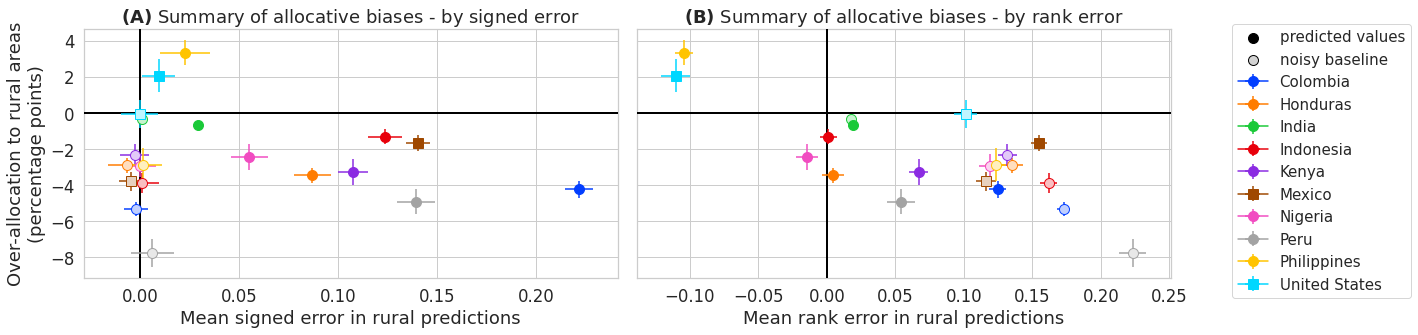

In [19]:
sns.set(style='whitegrid', font_scale=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 5),sharey=True)
colors = sns.color_palette("bright")

rural_mses, rural_mres, alloc_difs = [], [], []
for c, country in enumerate(country_code_order):
    for i in [1, 0]:
        marker = 's' if country in ['us', 'mexico'] else 'o'
        results_all = all_runs[country]
        results = [result[i] for result in results_all]
        rural_mse = np.mean([val['mae_above'] for val in results])
        rural_mre = np.mean([val['rank_above'] for val in results])
        rural_mse_conf = 2*sem([val['mae_above'] for val in results])
        rural_mre_conf = 2*sem([val['rank_above'] for val in results])
        alloc_dif = np.mean([val['group_alloc_proxy'] - val['group_alloc_true']  for val in results])
        alloc_dif_conf = 2*sem([val['group_alloc_proxy'] - val['group_alloc_true']  for val in results])

        if i == 0: 
            label = get_title(country)
            color = colors[c]
            edgecolor = colors[c]
            facecolor = colors[c]
            order = 200
        else: 
            label = None
            alpha = 0.2
            color = colors[c] #+ (alpha,)
            edgecolor = colors[c] 
            facecolor = [1 - (1-x)/4 for x in colors[c]]
            order = 100
            
        ax[0].errorbar([rural_mse], [alloc_dif], color=color, markersize=10, label=label, 
                       markerfacecolor=facecolor,
                       marker=marker, xerr=rural_mse_conf, yerr=alloc_dif_conf, zorder=order)

        ax[1].errorbar([rural_mre], [alloc_dif], color=color, markersize=10, label=label, 
                       markerfacecolor=facecolor,
                       marker=marker, xerr=rural_mre_conf, yerr=alloc_dif_conf, zorder=order)
        
xlim, ylim = ax[-1].get_xlim(), ax[-1].get_ylim()

ax[-1].scatter([-100], [100],
               s=100,
                color='black',
                label=f'predicted values')
ax[-1].scatter([-100], [100],
               s=100,
                    color='lightgrey',
                    edgecolor='black',
                    label=f'noisy baseline')
ax[-1].set_xlim(xlim)
ax[-1].set_ylim(ylim)

ax[0].set_ylabel('Over-allocation to rural areas\n(percentage points)')
#ax[1].set_ylabel('Over-allocation to rural areas\n(percentage points)')
ax[0].set_xlabel('Mean signed error in rural predictions')
ax[1].set_xlabel('Mean rank error in rural predictions')
ax[0].axhline(0, color='black', linewidth=2, zorder=10)
ax[0].axvline(0, color='black', linewidth=2, zorder=10)
ax[1].axhline(0, color='black', linewidth=2, zorder=10)
ax[1].axvline(0, color='black', linewidth=2, zorder=10)
ax[1].legend(bbox_to_anchor=(1.1, 1.05), fontsize='small')
ax[0].set_title(r"$\bf{(A)}$ Summary of allocative biases - by signed error")
ax[1].set_title(r"$\bf(B)}$ Summary of allocative biases - by rank error")


plt.tight_layout()
#plt.savefig(f'{figure_path}/Figure3.png')
plt.show()

# Figure S5

In [20]:
def make_plots(results, ax, country):
    ax_1a = ax[0]
    ax_1b = ax[1]
    ax_2aline = ax[2]
    ax_2acurve = ax[3]

    # -------------------------------------------------------------------------------------------------------

    # First plot set-up
    measure = 'mae'
    width = 0.15
    xaxis1 = np.arange(1)
    xaxis2 = np.arange(1) + width
    xaxis3 = np.arange(1) + 2*width
    xaxis4 = np.arange(1) + 3*width
    markersize_pred = 15
    markersize_noised = 12
    alpha_pred = 1.0
    alpha_noised = 0.3
    marker_pred = 'o'
    marker_noised = 'D'

    # First plot: horizontal lines for overall spearman 
    if True:
        overall_mean = np.mean([result[0]['mae_overall'] for result in results])
        overall_sem = sem([result[0]['mae_overall'] for result in results])
        ax_1a.axhline(overall_mean, color='grey', dashes=[4, 4], label='Overall Error')
        ax_1a.fill_between([-0.15, len(xaxis1) - 0.4], [overall_mean - 2*overall_sem, overall_mean - \
                                                        2*overall_sem],
                           [overall_mean + 2*overall_sem, overall_mean + 2*overall_sem], color='grey', 
                           alpha=0.2,)

    for vals, flag, ax1, ax2 in [([result[0] for result in results], 'Predicted', xaxis1, xaxis2), 
                                ([result[1] for result in results], 'Noisy Baseline', xaxis3, xaxis4)]:

        # First plot: MAE by group for predicted labels
        means_above = [np.mean([val['mae_above'] for val in vals]) for var in ['rural']]
        means_below = [np.mean([val['mae_below'] for val in vals]) for var in ['rural']]
        stds_above = [2*sem([val['mae_above'] for val in vals]) for var in ['rural']]
        stds_below = [2*sem([val['mae_below'] for val in vals]) for var in ['rural']]
        if flag == 'Predicted':
            ax_1a.errorbar(ax1, means_below, stds_below, label='Urban', color='steelblue', 
                           lw=2, capsize=7, capthick=3, ls='', marker=marker_pred, elinewidth=3, 
                           markersize=markersize_pred,alpha=alpha_pred)
            ax_1a.errorbar(ax2, means_above, stds_above, label='Rural', color='indianred', lw=2, 
                           capsize=7, capthick=3, ls='', marker=marker_pred, elinewidth=3, 
                           markersize=markersize_pred,alpha=alpha_pred)

            #for i, (mean_below, mean_above) in enumerate(zip(means_below,means_above)):
            #    ax_1a.plot([i+.08,i+.08], [mean_below, mean_above], color='black')
            #    stars = diff_in_means_stars([val[f'{measure}_above'] for val in vals], 
                                            # [val[f'{measure}_below'] for val in vals]) 

        # First plot: MAE by group for noised labels
        else:
            ax_1a.errorbar(ax1, means_below, stds_below, color='steelblue', markeredgewidth=3,lw=2, capsize=7, 
                           capthick=3, ls='', marker=marker_noised, elinewidth=3, markersize=markersize_noised, 
                           alpha=alpha_noised)
            ax_1a.errorbar(ax2, means_above, stds_above, 
                           color='indianred', markeredgewidth=3, lw=2, capsize=7, capthick=3, ls='', 
                           marker=marker_noised, elinewidth=3, markersize=markersize_noised, alpha=alpha_noised)

            #for i, (mean_below, mean_above) in enumerate(zip(means_below,means_above)):
            #    ax_1a.plot([i+.38,i+.38], [mean_below, mean_above], color='black', ls = ':')

        # Subplot clean-up
        ax_1a.set_xticks([(xaxis1[0]+ xaxis2[0])/2, (xaxis3[0]+ xaxis4[0])/2])
        ax_1a.set_xticklabels(['Satellite-\npredicted\nwealth', 'Noised\nwealth'])
        ax_1a.set_ylabel('Mean signed error')
        ax_1a.set_title('(i) Mean signed error')
        clean_plot(ax_1a)


    # ----------------------------------------------------------------------------------------------------
    # Second plot: horizontal lines for overall spearman 
    
    # Second plot set-up
    measure = 'rank'
    width = 0.15
    xaxis1 = np.arange(1)
    xaxis2 = np.arange(1) + width
    xaxis3 = np.arange(1) + 2*width
    xaxis4 = np.arange(1) + 3*width
    markersize_pred = 15
    markersize_noised = 12
    alpha_pred = 1.0
    alpha_noised = 0.3
    marker_pred = 'o'
    marker_noised = 'D'

    for vals, flag, ax1, ax2 in [([result[0] for result in results], 'Predicted', xaxis1, xaxis2), 
                                ([result[1] for result in results], 'Noisy Baseline', xaxis3, xaxis4)]:

        # First plot: MAE by group for predicted labels
        means_above = [np.mean([val['rank_above'] for val in vals]) for var in ['rural']]
        means_below = [np.mean([val['rank_below'] for val in vals]) for var in ['rural']]
        stds_above = [2*sem([val['rank_above'] for val in vals]) for var in ['rural']]
        stds_below = [2*sem([val['rank_below'] for val in vals]) for var in ['rural']]
        if flag == 'Predicted':
            ax_1b.errorbar(ax1, means_below, stds_below, label='urban regions ' + flag, color='steelblue', 
                           lw=2, capsize=7, capthick=3, ls='', marker=marker_pred, elinewidth=3, 
                           markersize=markersize_pred,alpha=alpha_pred)
            ax_1b.errorbar(ax2, means_above, stds_above, label='rural regions ' + flag, color='indianred', lw=2, 
                           capsize=7, capthick=3, ls='', marker=marker_pred, elinewidth=3, 
                           markersize=markersize_pred,alpha=alpha_pred)

            #for i, (mean_below, mean_above) in enumerate(zip(means_below,means_above)):
            #    ax_1b.plot([i+.08,i+.08], [mean_below, mean_above], color='black')
            #    stars = diff_in_means_stars([val[f'{measure}_above'] for val in vals], 
                                            # [val[f'{measure}_below'] for val in vals]) 

        # First plot: MAE by group for noised labels
        else:
            ax_1b.errorbar(ax1, means_below, stds_below, label='urban regions - ' + flag, color='steelblue', 
                           markeredgewidth=3,lw=2, capsize=7, capthick=3, ls='', 
                           marker=marker_noised, elinewidth=3, markersize=markersize_noised, alpha=alpha_noised)
            ax_1b.errorbar(ax2, means_above, stds_above, label='rural regions - ' + flag, 
                           color='indianred',markeredgewidth=3, lw=2, capsize=7, capthick=3, ls='', 
                           marker=marker_noised, elinewidth=3, markersize=markersize_noised, alpha=alpha_noised)

            #for i, (mean_below, mean_above) in enumerate(zip(means_below,means_above)):
            #    ax_1b.plot([i+.38,i+.38], [mean_below, mean_above], color='black', ls = ':')

        # Subplot clean-up
        ax_1b.set_xticks([(xaxis1[0]+ xaxis2[0])/2, (xaxis3[0]+ xaxis4[0])/2])
        ax_1b.set_xticklabels(['Satellite-\npredicted\nwealth', 'Noised\nwealth'])
        ax_1b.set_ylabel('Mean rank error')
        ax_1b.set_title('(ii) Mean rank error')
        clean_plot(ax_1b)



    # ----------------------------------------------------------------------------------------------------

    # Third and fourth plots set-up
    runs = len(results)
    g = 'group_' 
    allocations_true = {'rural':[results[i][0][g + 'alloc_true'] for i in range(runs)]}
    allocations_proxy = {'rural':[results[i][0][g + 'alloc_proxy'] for i in range(runs)]}
    allocations_noised = {'rural':[results[i][1][g +'alloc_proxy'] for i in range(runs)]}

    curves_true = {'rural':[results[i][0][g + 'alloc_curve_true'] for i in range(runs)]}
    curves_proxy = {'rural':[results[i][0][g + 'alloc_curve_proxy'] for i in range(runs)]}
    curves_noised = {'rural':[results[i][1][g + 'alloc_curve_proxy'] for i in range(runs)]}


    for var in ['rural']:

        # Plot of allocations at threshold
        allocations_means = [np.mean(allocations_true[var]), 
                             np.mean(allocations_proxy[var]),
                             np.mean(allocations_noised[var])]
        allocations_stds = [2*sem(allocations_true[var]), 2*sem(allocations_proxy[var]),
                            2*sem(allocations_noised[var])]
        for i, (c, mstyle, msize) in enumerate(zip(['mediumseagreen', 'orange', 'grey'],
                                                   ['s','o','D',],
                                                   [markersize_noised, markersize_pred,markersize_noised])):
            ax_2aline.errorbar([i], allocations_means[i], allocations_stds[i],
                              color=c, alpha=1,
                              marker=mstyle,
                              lw=2, capsize=7, capthick=3, ls='', elinewidth=3, markersize=msize)
            ax_2aline.fill_between([i-0.1,i+0.1],
                                 [allocations_means[i]-allocations_stds[i]]*2, 
                                 [allocations_means[i]+allocations_stds[i]]*2,
                                   color=c, alpha=0.15)
            ax_2aline.set_xlim(-.5,2.5)
            ax_2aline.set_xticks([0,1,2])
            ax_2aline.set_xticklabels(['Wealth', 'Satellite-\npredicted\nwealth', 'Noised\nwealth'])
            ax_2aline.set_title('(iii) Rural allocation at 20%')
            ax_2acurve.set_title('(iv) Rural allocation at all thresholds')
            ax_2aline.yaxis.set_major_formatter(mtick.PercentFormatter())
            ax_2aline.set_ylabel('% of aid to rural regions')

        # Line plot of allocations across all thresholds
        grid = np.arange(3, 101, 1)
        ss = np.sqrt(len(results))
        curve_true = np.array(curves_true[var])
        curve_noised = np.array(curves_noised[var])
        curve_proxy = np.array(curves_proxy[var])
        ax_2acurve.plot(grid, np.mean(curve_true, axis=0), linewidth=2, color='mediumseagreen',
                       label='Wealth')
        ax_2acurve.fill_between(grid, 
            np.mean(curve_true, axis=0) - 2*np.std(curve_true, axis=0, ddof=1)/ss, 
            np.mean(curve_true, axis=0) + 2*np.std(curve_true, axis=0, ddof=1)/ss, 
            color='mediumseagreen', alpha=0.3)
        ax_2acurve.plot(grid, np.mean(curve_proxy, axis=0), linewidth=2, color='orange', 
                        label='Satellite-predicted wealth')
        ax_2acurve.fill_between(grid, 
            np.mean(curve_proxy, axis=0) - 2*np.std(curve_proxy, axis=0, ddof=1)/ss, 
            np.mean(curve_proxy, axis=0) + 2*np.std(curve_proxy, axis=0, ddof=1)/ss, 
            color='orange', alpha=0.3)
        ax_2acurve.plot(grid, np.mean(curve_noised, axis=0),  linewidth=2, color='grey',
                       label='Noised wealth')
        ax_2acurve.fill_between(grid, 
            np.mean(curve_noised, axis=0) - 2*np.std(curve_noised, axis=0, ddof=1)/ss, 
            np.mean(curve_noised, axis=0) + 2*np.std(curve_noised, axis=0, ddof=1)/ss, color='grey', alpha=0.5)

        ax_2acurve.set_xlim(3, 100)
        ax_2acurve.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax_2acurve.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax_2acurve.set_xlabel('% of regions targeted')
        ax_2acurve.set_ylabel('% of aid to rural regions')
        

    # ---------------------------------------------------------------------------------------------
    def integer_percent_format(ax):
        ax.set_major_locator(mtick.MaxNLocator(6, integer=True))
        ax.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
        ax.set_major_formatter(mtick.PercentFormatter(decimals=0))

    for ax_this in [ax_2acurve, ax_2aline]:
        integer_percent_format(ax_this.yaxis)

    for ax_this in ax.ravel():
        clean_plot(ax_this)

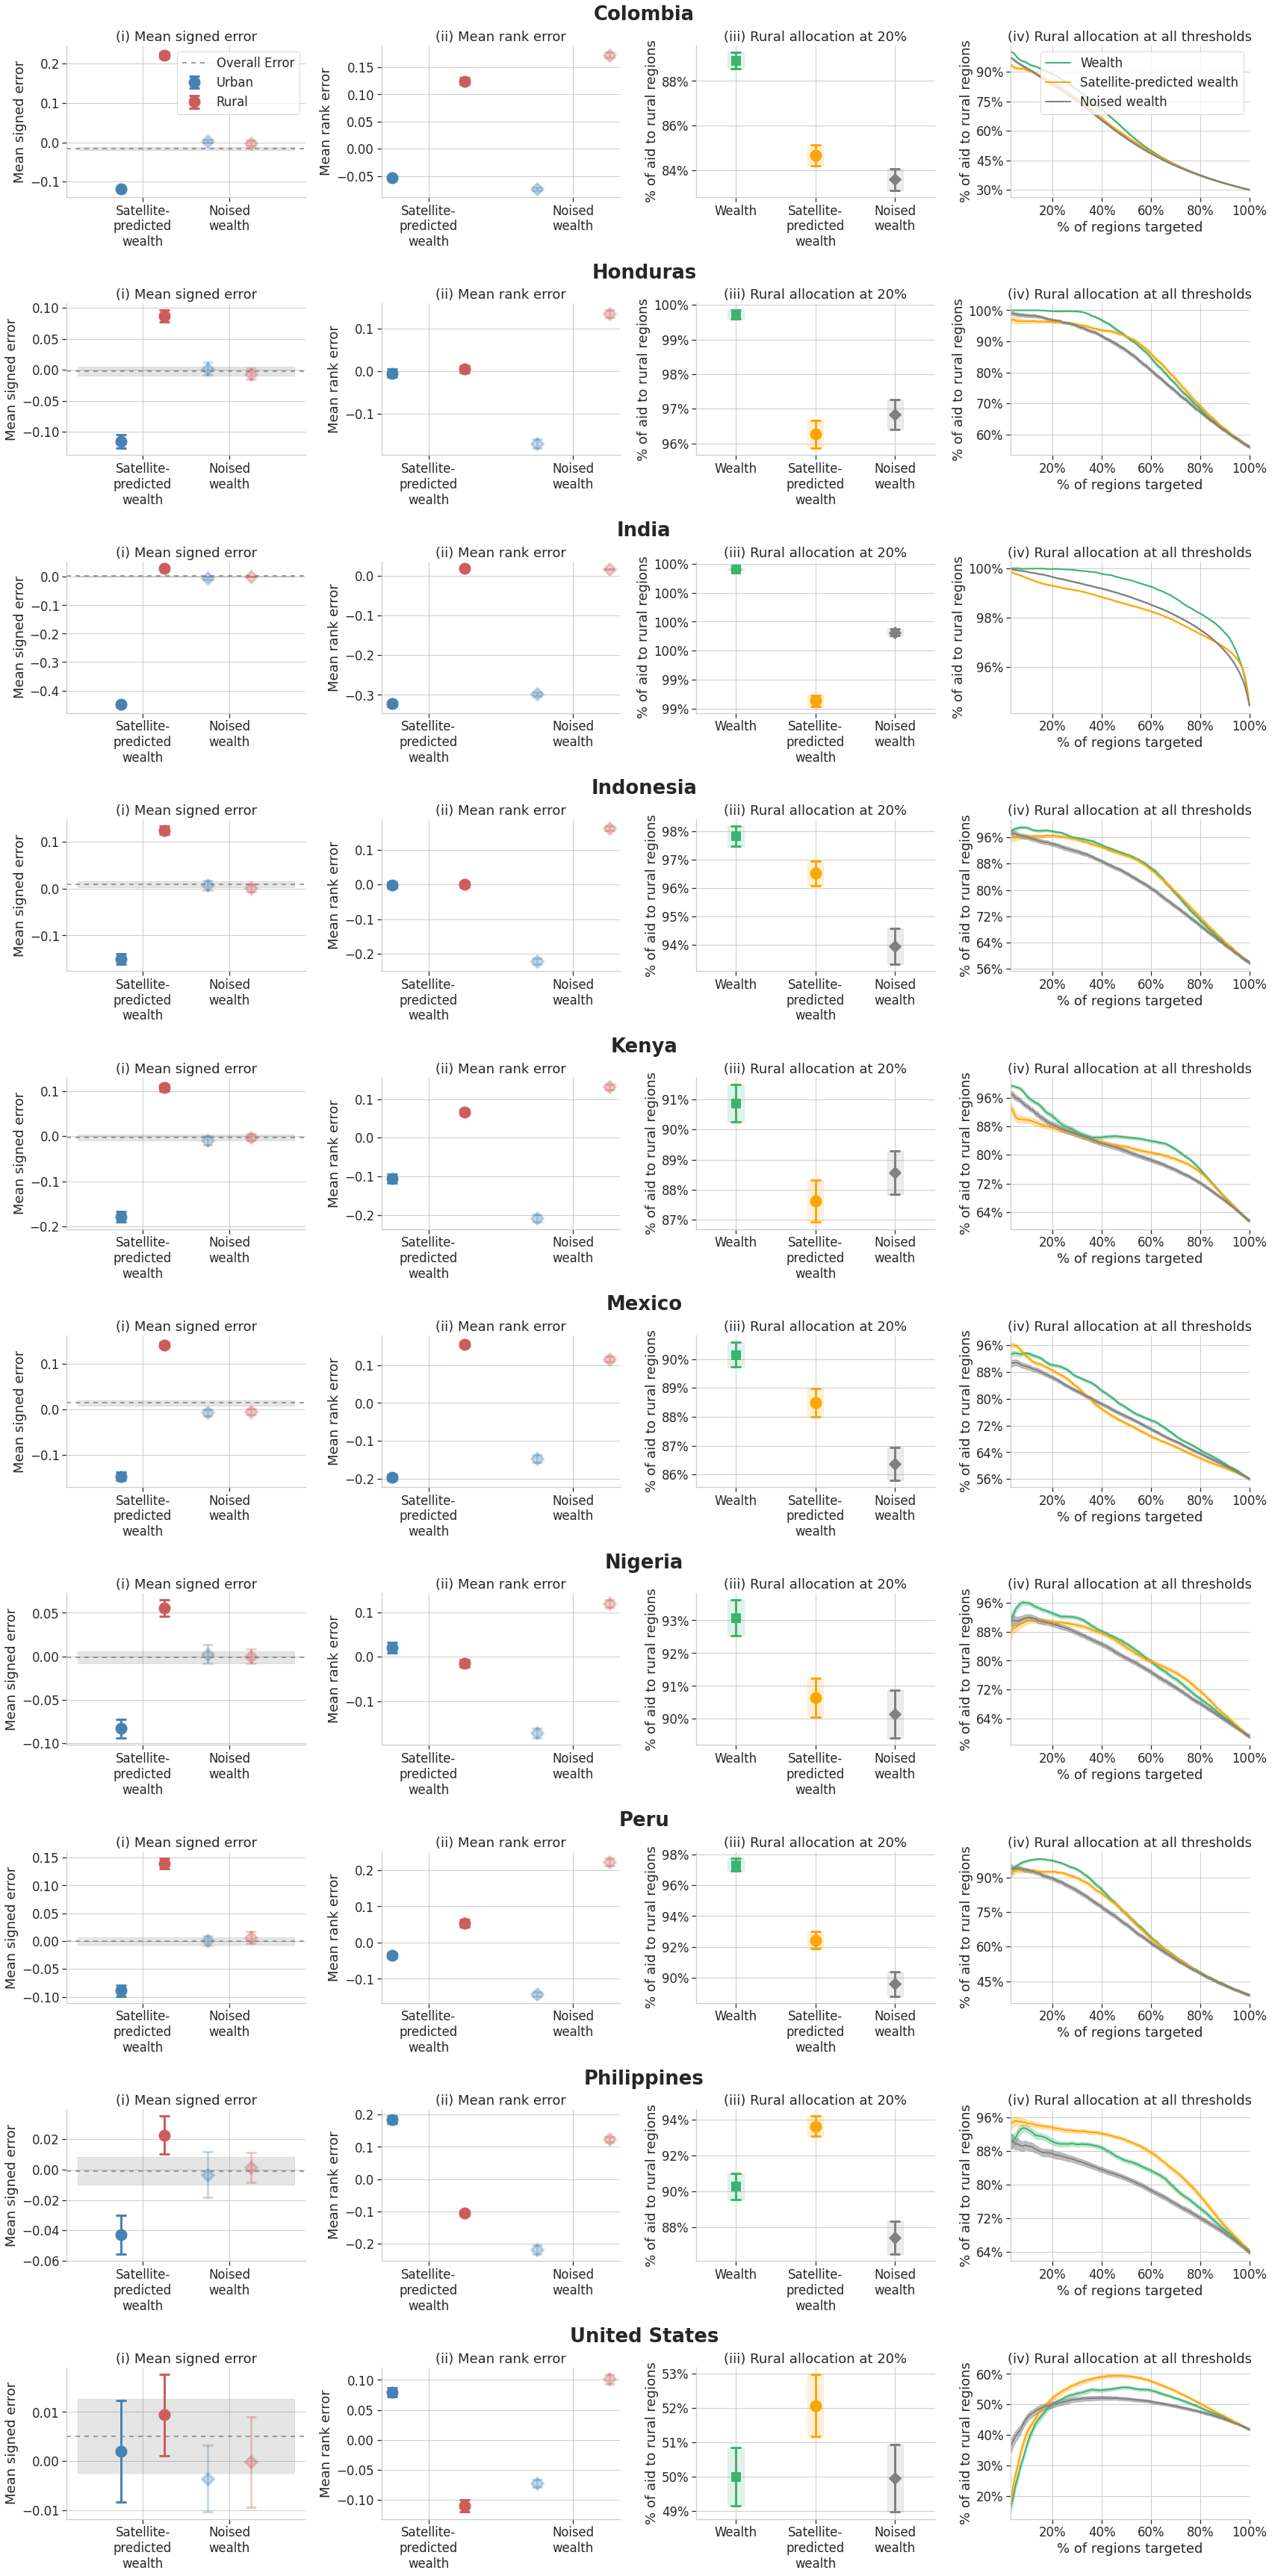

In [21]:
# Figure set-up
sns.set(style='whitegrid', font_scale=1.5)
fig, axes = plt.subplots(len(all_runs.keys()), 4, figsize=(24, 50))

for c, country in enumerate(country_code_order):
    results = all_runs[country]
    make_plots(results, axes[c, :], country)

axes[0][0].legend(loc='best')
axes[0][3].legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(top = 0.96, bottom=0.04, hspace=0.7)

for ax, row in zip(axes[:, 1], [get_title(x) for x in country_code_order]):
    ax.annotate(row, xy=(1.1, 1.2),  xycoords='axes fraction', size='large', ha='center', va='center', 
               fontsize='x-large', fontweight='bold', annotation_clip=False)

#plt.savefig(f'{figure_path}/FigureS5', dpi=500)
plt.show()

# Table S2

In [22]:
alloc_table, auc_table = [], []
for c, country in enumerate(country_names):
    runs = all_runs[country]
    
    alloc_predicted = np.mean([runs[i][0]['group_alloc_proxy'] for i in range(len(runs))])
    alloc_true = np.mean([runs[i][0]['group_alloc_true'] for i in range(len(runs))])
    alloc_difference = alloc_predicted - alloc_true
    alloc_pvalue = ttest_rel([runs[i][0]['group_alloc_proxy'] for i in range(len(runs))],
                                         [runs[i][0]['group_alloc_true'] for i in range(len(runs))]).pvalue
    alloc_difference_stars = '***' if alloc_pvalue < 0.001 else '**' if alloc_pvalue < 0.01 else  '*' \
        if alloc_pvalue < 0.05 else '' 

    auc_predicted = np.mean([runs[i][0]['auc_proxy'] for i in range(len(runs))])
    auc_true = np.mean([runs[i][0]['auc_true'] for i in range(len(runs))])
    auc_difference = auc_predicted - auc_true
    auc_pvalue = ttest_rel([runs[i][0]['auc_proxy'] for i in range(len(runs))],
                           [runs[i][0]['auc_true'] for i in range(len(runs))]).pvalue
    auc_difference_stars = '***' if auc_pvalue < 0.001 else '**' if auc_pvalue < 0.01 else  '*' \
        if auc_pvalue < 0.05 else '' 

    std_difs = [runs[i][0]['std'] - runs[i][0]['std_truth'] for i in range(len(runs))]
    alloc_difs_allocation = [runs[i][0]['group_alloc_proxy'] - 
                  runs[i][0]['group_alloc_true'] for i in range(len(runs))]
    alloc_difs_auc = [runs[i][0]['auc_proxy'] - 
                  runs[i][0]['auc_true'] for i in range(len(runs))]
    urban_corrs = [runs[i][0]['urban_wealth_corr'] for i in range(len(runs))]
    
    alloc_row = [get_title(country), '%.3f' % alloc_predicted.round(3), '%.3f' % alloc_true.round(3), 
                 '%.3f' % alloc_difference.round(3) + alloc_difference_stars, 
                 '%.3f' % np.corrcoef(std_difs, alloc_difs_allocation)[0][1].round(3),
                 '%.3f' % np.corrcoef(urban_corrs, alloc_difs_allocation)[0][1].round(3)]
    alloc_table.append(alloc_row)
    
    auc_row = [get_title(country), '%.3f' % (auc_predicted/10000).round(3), '%.3f' % (auc_true/10000).round(3), 
               ('%.3f' % (auc_difference/10000).round(3)) + auc_difference_stars, 
               '%.3f' % np.corrcoef(std_difs, alloc_difs_auc)[0][1].round(3),
               '%.3f' % np.corrcoef(urban_corrs, alloc_difs_auc)[0][1].round(3)]
    auc_table.append(auc_row)

alloc_table = pd.DataFrame(alloc_table)
auc_table = pd.DataFrame(auc_table)

alloc_table.columns = ['Country', 'Allocation (predicted)', 'Allocation (true)', 'Difference', 
                      'Corr(P1, Allocation Difference)', 'Corr(P2, Allocation Difference)']
auc_table.columns = ['Country', 'AUC (predicted)', 'AUC (true)', 'Difference', 
                      'Corr(P1, AUC Difference)', 'Corr(P2, AUC Difference)']
alloc_table['order'] = [10, 6, 3, 1, 2, 4, 7, 5, 9, 8]
auc_table['order'] = [10, 6, 3, 1, 2, 4, 7, 5, 9, 8]

In [23]:
alloc_table.sort_values('order', ascending=True)

,Country,Allocation (predicted),Allocation (true),Difference,"Corr(P1, Allocation Difference)","Corr(P2, Allocation Difference)",order
3,Colombia,84.684,88.918,-4.234***,0.026,0.105,1
4,Honduras,96.263,99.719,-3.456***,0.097,-0.094,2
2,India,99.290,99.972,-0.682***,-0.091,0.115,3
5,Indonesia,96.515,97.818,-1.303***,-0.124,-0.056,4
7,Kenya,87.612,90.888,-3.275***,-0.306,0.014,5
1,Mexico,88.496,90.154,-1.659***,-0.100,0.111,6
6,Nigeria,90.652,93.072,-2.420***,-0.047,-0.110,7
9,Peru,92.439,97.351,-4.912***,-0.126,0.042,8
8,Philippines,93.623,90.279,3.344***,-0.057,0.193,9
0,United States,52.077,50.000,2.077***,-0.110,0.469,10


In [24]:
auc_table.sort_values('order', ascending=True)

,Country,AUC (predicted),AUC (true),Difference,"Corr(P1, AUC Difference)","Corr(P2, AUC Difference)",order
3,Colombia,0.572,0.594,-0.022***,0.063,0.044,1
4,Honduras,0.816,0.827,-0.010***,-0.015,0.107,2
2,India,0.953,0.961,-0.007***,-0.090,-0.032,3
5,Indonesia,0.821,0.826,-0.005***,-0.046,0.129,4
7,Kenya,0.781,0.804,-0.023***,-0.273,-0.012,5
1,Mexico,0.718,0.745,-0.027***,0.124,0.185,6
6,Nigeria,0.783,0.790,-0.007***,-0.049,-0.070,7
9,Peru,0.682,0.696,-0.015***,-0.159,0.169,8
8,Philippines,0.834,0.804,0.030***,-0.154,0.187,9
0,United States,0.500,0.476,0.024***,-0.167,0.488,10


### Figure S3

In [25]:
outlines = gpd.read_file('/data/mosaiks/shapefiles/countries.geojson')

In [26]:
countries = [('dhs/colombia', 'wealth', 'cluster'),
             ('dhs/honduras', 'wealth', 'cluster'),
             ('india_condensed_regions_25_max_tiles_100', 'secc_cons_pc_combined', 'condensed_shrug_id'),
             ('dhs/indonesia', 'wealth', 'cluster'),
             ('dhs/kenya', 'wealth', 'cluster'),
             ('mexico', 'asset_index', 'municipality'),
             ('dhs/nigeria', 'wealth', 'cluster'),
             ('dhs/peru', 'wealth', 'cluster'),
             ('dhs/philippines', 'wealth', 'cluster'),
             ('us', 'FINCP', 'StatePUMA'),    
]

In [27]:
sns.reset_orig()

dhs/colombia
dhs/honduras
india_condensed_regions_25_max_tiles_100
dhs/indonesia
dhs/kenya
mexico
dhs/nigeria
dhs/peru
dhs/philippines
us


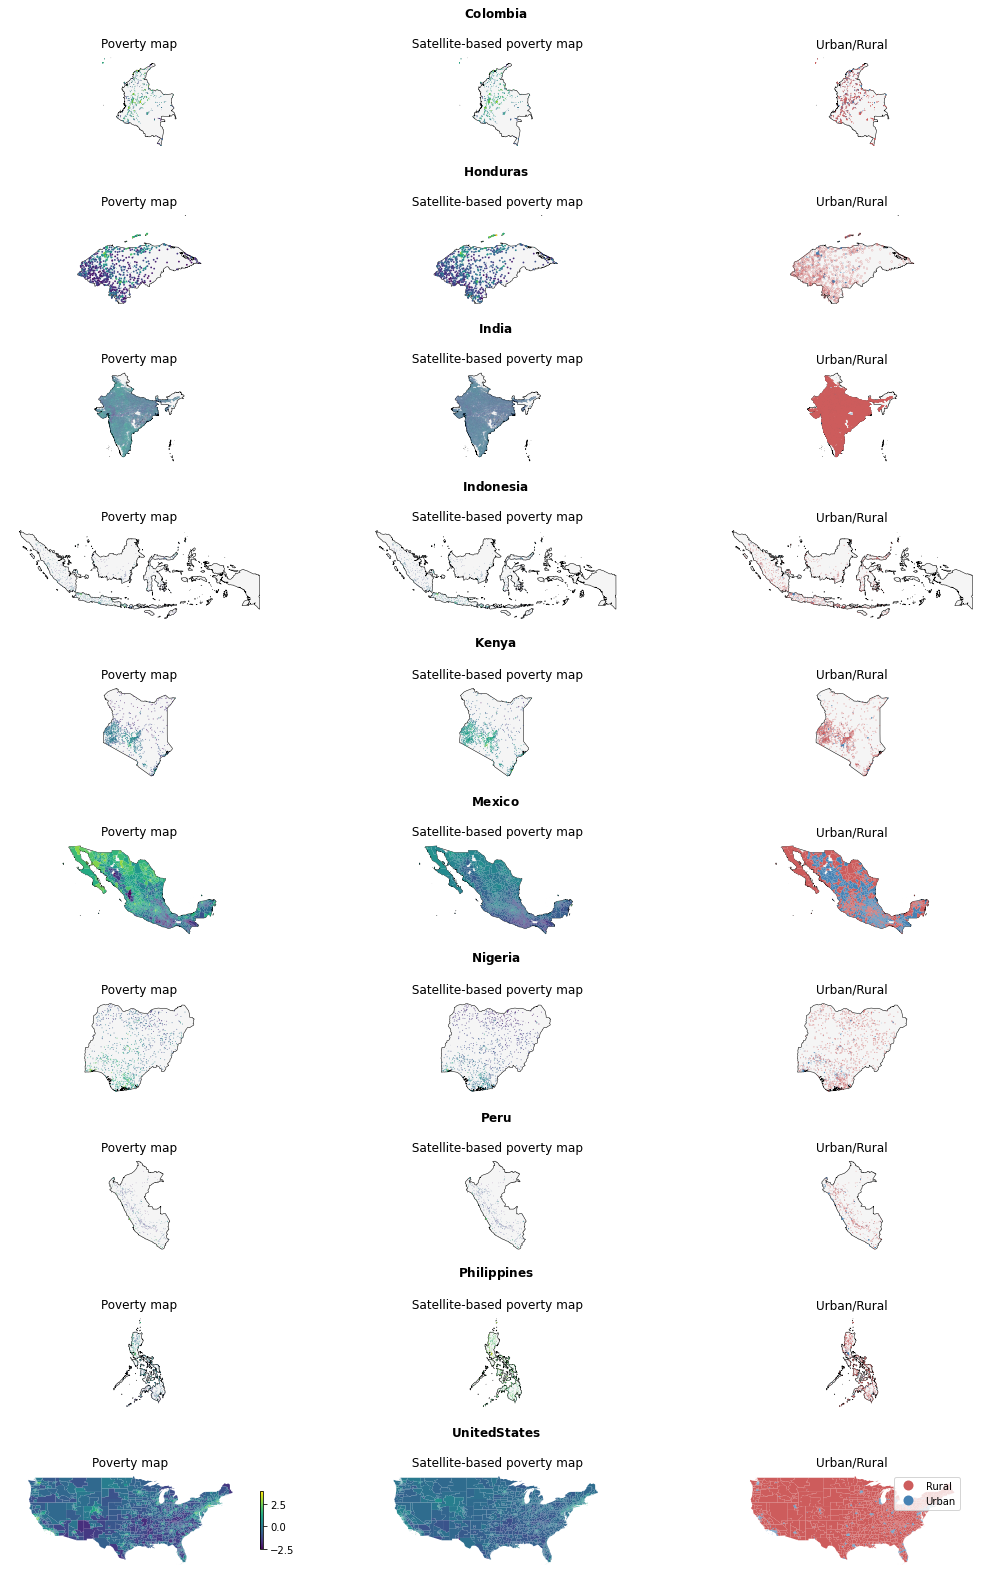

In [28]:
fig, ax = plt.subplots(len(countries), 3, figsize=(15, 22))

counter = 0
for country, poverty, key in countries:
    
    print(country)
    
    country_name = get_title(country)
    if country == 'us':
        key = ['State', 'PUMA']
    
    sims = pd.read_csv('/data/mosaiks/simulations_normalized/' + country + '/' + poverty + '_no_spatial.csv')
    sims = sims[sims['split'] == 'test']
    if 'india' in country:
        ids = pd.read_csv('/data/mosaiks/simulations_normalized/' + country + '/ids.csv')
    else:
        ids = pd.read_csv('/data/mosaiks/simulations/' + country + '/ids.csv')
    
    sims = sims.merge(ids, on='Unnamed: 0', how='inner')
    sims = sims.groupby(key).agg('median')
    
    if country != 'us':
        outline = outlines[outlines['ADMIN'] == country_name]
        outline.plot(ax=ax[counter, 0], color='whitesmoke', edgecolor='black', linewidth=0.5)
        outline.plot(ax=ax[counter, 1], color='whitesmoke', edgecolor='black', linewidth=0.5)
        outline.plot(ax=ax[counter, 2], color='whitesmoke', edgecolor='black', linewidth=0.5)

    if 'us' in country:
        us = gpd.read_file('/data/mosaiks/shapefiles/us_pumas/pumas.shp')
        labels = pd.read_csv('/data/mosaiks/surveys/us/groundtruth_by_puma_2019.csv')
        us = us.merge(labels, on=['State', 'PUMA'])
        us['rural'] = us['rural'].apply(lambda x: 'Rural' if x == 1 else 'Urban')
        us[poverty] = np.log(us[poverty]+1)
        mean_pov, std_pov = us[poverty].mean(), us[poverty].std()
        us[poverty] = (us[poverty] - mean_pov)/std_pov
        us.plot(ax=ax[counter, 0], column=poverty, cmap='viridis', legend=True, legend_kwds={'shrink':0.6})
        us.plot(ax=ax[counter, 2], column='rural', cmap=ListedColormap(['indianred', 'steelblue']), legend=True)
        predictions = us.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')
        
    if 'mexico' in country:
        mexico = gpd.read_file('/data/mosaiks/shapefiles/mexico_municipalities.geojson')
        labels = pd.read_csv('/data/mosaiks/surveys/mexico/grouped.csv')
        mexico = mexico.merge(labels, on='municipality', how='inner')
        mean_pov, std_pov = mexico[poverty].mean(), mexico[poverty].std()
        mexico[poverty] = (mexico[poverty] - mean_pov)/std_pov
        mexico.plot(ax=ax[counter, 0], column=poverty, cmap='viridis')
        mexico.plot(ax=ax[counter, 2], column='rural', cmap=ListedColormap(['indianred', 'steelblue']))
        predictions = mexico.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')

    if 'dhs' in country:
        clusters = gpd.read_file('/data/mosaiks/surveys/dhs/' + country[4:] + '_polygons.geojson')
        labels = pd.read_csv('/data/mosaiks/surveys/' + country + '_grouped.csv')
        clusters = clusters.merge(labels, on='cluster', how='inner')
        mean_pov, std_pov = clusters[poverty].mean(), clusters[poverty].std()
        clusters[poverty] = (clusters[poverty] - mean_pov)/std_pov
        clusters['area'] = clusters['geometry'].area
        urban = clusters[clusters['area'] < 0.005]
        rural = clusters[clusters['area'] > 0.005]
        clusters.plot(ax=ax[counter, 0], column=poverty)
        urban.plot(ax=ax[counter, 2], facecolor='none', edgecolor='steelblue', linewidth=0.2)
        rural.plot(ax=ax[counter, 2], facecolor='none', edgecolor='indianred', linewidth=0.2)
        predictions = clusters.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')
        
    if 'india' in country:
        shrug_data = gpd.read_file('/data/mosaiks/shrug/shrug_condensed_regions_25.geojson')     
        urban = shrug_data[shrug_data['rural'] == False]
        rural = shrug_data[shrug_data['rural'] == True]
        shrug_data[poverty] = np.log(shrug_data[poverty]+1)
        mean_pov, std_pov = shrug_data[poverty].mean(), shrug_data[poverty].std()
        shrug_data[poverty] = (shrug_data[poverty] - mean_pov)/std_pov
        
        predictions = shrug_data.merge(sims, on=key, how='inner')
        
        shrug_data.plot(ax=ax[counter, 0], column=poverty)
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')
        urban.plot(ax=ax[counter, 2], facecolor='none', edgecolor='steelblue', linewidth=0.2)
        rural.plot(ax=ax[counter, 2], facecolor='none', edgecolor='indianred', linewidth=0.2)

        
        
    
    ax[counter, 0].axis('off')
    ax[counter, 1].axis('off')
    ax[counter, 2].axis('off')
    
    ax[counter, 0].set_title('Poverty map')
    ax[counter, 1].set_title(r"$\bf{" + country_name + "}$" + '\n\n Satellite-based poverty map')
    ax[counter, 2].set_title('Urban/Rural')
    
    counter += 1

plt.tight_layout()
#plt.savefig(f'{figure_path}/Figure3.png', dpi=500)
plt.show()